In [21]:
import joblib
outs = joblib.load("outputs/artifacts/algo1_outs.pkl")

/opt/anaconda3/envs/csiro_stem/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/csiro_stem/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1/500  Train NLL: 8.3135e+04  Test NLL: 2.0939e+04
Epoch 2/500  Train NLL: 1.0481e+04  Test NLL: 4.3381e+03
Epoch 3/500  Train NLL: 2.7489e+03  Test NLL: 1.4383e+03
Epoch 4/500  Train NLL: 1.0210e+03  Test NLL: 6.1818e+02
Epoch 5/500  Train NLL: 4.7424e+02  Test NLL: 3.1016e+02
Epoch 6/500  Train NLL: 2.5286e+02  Test NLL: 1.7238e+02
Epoch 7/500  Train NLL: 1.4469e+02  Test NLL: 1.0308e+02
Epoch 8/500  Train NLL: 8.7831e+01  Test NLL: 6.4941e+01
Epoch 9/500  Train NLL: 5.6814e+01  Test NLL: 4.2411e+01
Epoch 10/500  Train NLL: 3.7730e+01  Test NLL: 2.8397e+01
Epoch 11/500  Train NLL: 2.5346e+01  Test NLL: 1.9244e+01
Epoch 12/500  Train NLL: 1.7519e+01  Test NLL: 1.3104e+01
Epoch 13/500  Train NLL: 1.1997e+01  Test NLL: 8.8344e+00
Epoch 14/500  Train NLL: 8.1259e+00  Test NLL: 5.8944e+00
Epoch 15/500  Train NLL: 5.5157e+00  Test NLL: 3.8080e+00
Epoch 16/500  Train NLL: 3.6423e+00  Test NLL: 2.4033e+00
Epoch 17/500  Train NLL: 2.3369e+00  Test NLL: 1.3668e+00
Epoch 18/500  Train NLL

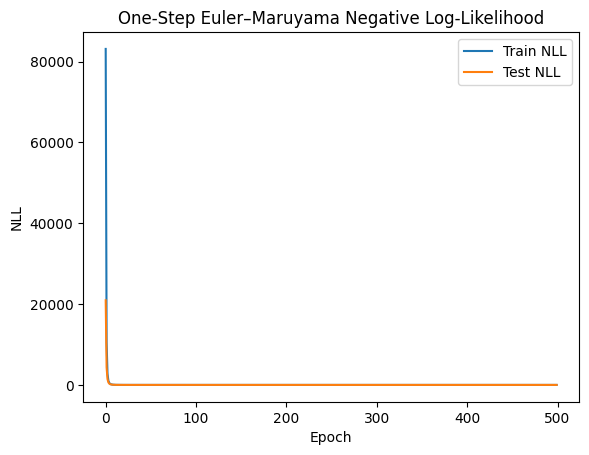

In [22]:
from neural_sde.loss import likelihood_training
train_losses, test_losses, sde_model, X_train = likelihood_training(
    outs,
    n_epochs=500,
    batch_size=128,
    lr=1e-3
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

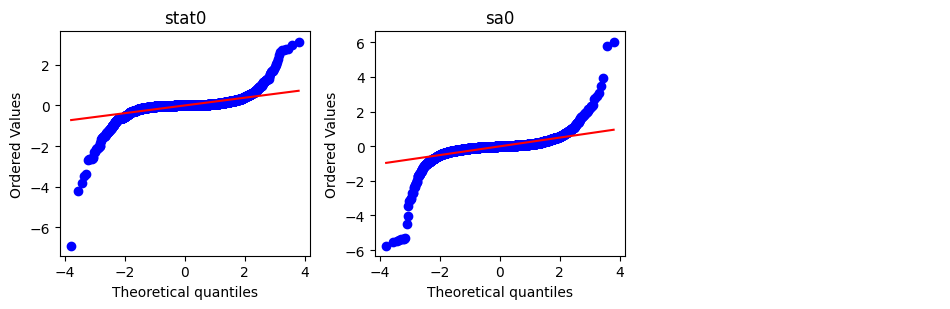

In [23]:
# In your neural_sde.ipynb after training
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import stats
from neural_sde.loss import build_xi_training_data  # -> [`neural_sde.loss.build_xi_training_data`](neural_sde/loss.py)

# 1) In-sample factor matrix (columns = factors: dyn | stat | sa)
X_train, _, names = build_xi_training_data(outs)  # names like ["dyn0","dyn1",...,"stat0",...,"sa0",...]

# 2) Compute dt in years from training timestamps (align lengths)
tt = pd.to_datetime(outs.C_train.index.values)
sec_per_year = 365.0 * 24 * 3600
dt = np.asarray((tt[1:] - tt[:-1]).total_seconds(), dtype=np.float64) / sec_per_year

L = min(len(dt), X_train.shape[0]-1)

device = next(sde_model.parameters()).device
Y0 = torch.from_numpy(X_train[:L]).float().to(device)
Y1 = torch.from_numpy(X_train[1:L+1]).float().to(device)
dt_t = torch.from_numpy(dt[:L].copy()).float().unsqueeze(1).clamp_min(1e-12).to(device)

with torch.no_grad():
    mu  = sde_model.f(0.0, Y0)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 3) One-step standardized residuals under the trained SDE
#    ε_t = (x_{t+1} - x_t - f(x_t)Δt) / (g(x_t)√Δt)
with torch.no_grad():
    mu = sde_model.f(0.0, Y0)                        # [`neural_sde.nets.NeuralSDE.f`](neural_sde/nets.py)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)       # [`neural_sde.nets.NeuralSDE.g`](neural_sde/nets.py)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 4) QQ plots per factor
d = resid.shape[1]
cols = 3
rows = int(np.ceil(d/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.2))
axes = axes.ravel()

for j in range(d):
    stats.probplot(resid[:, j], dist="norm", plot=axes[j])
    axes[j].set_title(names[j] if names else f"factor {j}")

for k in range(d, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()



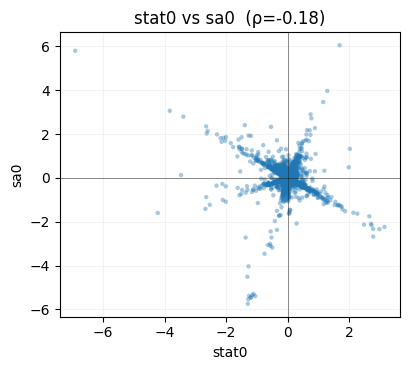

In [24]:
# Pairwise scatter plots of residuals
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math

R = np.asarray(resid, float)  # shape (T-1, d)
d = R.shape[1]
labels = names if (isinstance(names, (list, tuple)) and len(names)==d) else [f"f{j}" for j in range(d)]

pairs = list(combinations(range(d), 2))
cols = min(3, len(pairs))
rows = math.ceil(len(pairs) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.8), squeeze=False)

for ax, (i, j) in zip(axes.ravel(), pairs):
    x, y = R[:, i], R[:, j]
    rho = np.corrcoef(x, y)[0, 1]
    ax.scatter(x, y, s=10, alpha=0.4, edgecolors="none")
    ax.axhline(0, color="k", lw=0.5, alpha=0.6)
    ax.axvline(0, color="k", lw=0.5, alpha=0.6)
    ax.set_xlabel(labels[i]); ax.set_ylabel(labels[j])
    ax.set_title(f"{labels[i]} vs {labels[j]}  (ρ={rho:.2f})")
    ax.grid(alpha=0.15)

# hide any unused axes
for k in range(len(pairs), rows*cols):
    fig.delaxes(axes.ravel()[k])

plt.tight_layout()
plt.show()